In [ ]:
import pandas as pd
import numpy as np
import glob as glob
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from pathlib import Path
import re

# Loading in chunks

In [2]:
chunk_umi_count_paths = glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*reads_per_umi.tsv")
len(chunk_umi_count_paths)

104

In [3]:
def count_unique_umis(path):
    try:
        df = pd.read_csv(path, sep="\t", usecols=["UMI"])
        return {
            "path": path,
            "unique_umis": df["UMI"].nunique()
        }
    except Exception as e:
        return {
            "path": path,
            "unique_umis": None,
            "error": str(e)
        }

# Number of workers (tune this)
N_JOBS = 24  # try 4–8 on shared filesystems

results = Parallel(n_jobs=N_JOBS)(
    delayed(count_unique_umis)(path)
    for path in tqdm(chunk_umi_count_paths)
)

df = pd.DataFrame(results)
df

100%|██████████| 104/104 [00:29<00:00,  3.48it/s]


,path,unique_umis
0,../../output/GCN4/downsampling/trebl_experimen...,1926085
1,../../output/GCN4/downsampling/trebl_experimen...,5990177
2,../../output/GCN4/downsampling/trebl_experimen...,5989578
3,../../output/GCN4/downsampling/trebl_experimen...,2732259
4,../../output/GCN4/downsampling/trebl_experimen...,1519924
...,...,...
99,../../output/GCN4/downsampling/trebl_experimen...,5988269
100,../../output/GCN4/downsampling/trebl_experimen...,7169011
101,../../output/GCN4/downsampling/trebl_experimen...,2249745
102,../../output/GCN4/downsampling/trebl_experimen...,1804186


In [4]:
df['num_splits'] = df['path'].str.extract(r'_(\d+)_chunks').astype(int)
df

,path,unique_umis,num_splits
0,../../output/GCN4/downsampling/trebl_experimen...,1926085,8
1,../../output/GCN4/downsampling/trebl_experimen...,5990177,20
2,../../output/GCN4/downsampling/trebl_experimen...,5989578,20
3,../../output/GCN4/downsampling/trebl_experimen...,2732259,3
4,../../output/GCN4/downsampling/trebl_experimen...,1519924,20
...,...,...,...
99,../../output/GCN4/downsampling/trebl_experimen...,5988269,20
100,../../output/GCN4/downsampling/trebl_experimen...,7169011,8
101,../../output/GCN4/downsampling/trebl_experimen...,2249745,5
102,../../output/GCN4/downsampling/trebl_experimen...,1804186,10


In [5]:
df["percent_reads"] = 100 / df["num_splits"]
df["time"] = df["path"].str.extract("RPTR_1_(\d+)_")
df

,path,unique_umis,num_splits,percent_reads,time
0,../../output/GCN4/downsampling/trebl_experimen...,1926085,8,12.500000,5
1,../../output/GCN4/downsampling/trebl_experimen...,5990177,20,5.000000,30
2,../../output/GCN4/downsampling/trebl_experimen...,5989578,20,5.000000,30
3,../../output/GCN4/downsampling/trebl_experimen...,2732259,3,33.333333,5
4,../../output/GCN4/downsampling/trebl_experimen...,1519924,20,5.000000,5
...,...,...,...,...,...
99,../../output/GCN4/downsampling/trebl_experimen...,5988269,20,5.000000,30
100,../../output/GCN4/downsampling/trebl_experimen...,7169011,8,12.500000,30
101,../../output/GCN4/downsampling/trebl_experimen...,2249745,5,20.000000,5
102,../../output/GCN4/downsampling/trebl_experimen...,1804186,10,10.000000,5


# Getting unique UMIs at 75% and 100% from 25% splits

In [6]:
def umi_coverage_for_timepoint(tsv_paths, timepoint):
    records = []

    # ---- Read + dedupe per file ----
    for path in tqdm(tsv_paths, desc="Reading TSVs", unit="file"):
        path = Path(path)
        m = re.search(r"_part_(\d+)", path.name)
        if not m:
            continue

        part = int(m.group(1))
        chunk_id = re.sub(r"_part_\d+.*", "", path.name)

        df = pd.read_csv(
            path,
            sep="\t",
            usecols=["UMI"],
            dtype="string",
        ).drop_duplicates()

        df["chunk_id"] = chunk_id
        df["part"] = part
        records.append(df)

    big = pd.concat(records, ignore_index=True)

    # ---- Keep only complete 4-part chunks ----
    valid_chunks = big.groupby("chunk_id")["part"].nunique().eq(4)
    big = big[big["chunk_id"].map(valid_chunks)]

    # ---- Compute true unions for each chunk ----
    rows = []
    for chunk_id, g in tqdm(big.groupby("chunk_id"), desc="Counting UMIs", unit="chunk"):
        umis_parts = {p: set(sub["UMI"]) for p, sub in g.groupby("part")}
        
        rows.extend([
            {
                "unique_umis": len(umis_parts[1] | umis_parts[2] | umis_parts[3]),
                "num_splits": 100/75,
                "percent_reads": 75.0,
                "time": timepoint,
            },
            {
                "unique_umis": len(umis_parts[2] | umis_parts[3] | umis_parts[4]),
                "num_splits": 100/75,
                "percent_reads": 75.0,
                "time": timepoint,
            },
            {
                "unique_umis": len(umis_parts[1] | umis_parts[2] | umis_parts[3] | umis_parts[4]),
                "num_splits": 1,
                "percent_reads": 100.0,
                "time": timepoint,
            },
        ])

    return pd.DataFrame(rows)

In [7]:
chunk_umi_30_25_count_paths = glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_30_*4_chunks_*reads_per_umi.tsv")
chunk_umi_30_25_count_paths

['../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_1/RPTR_1_30_S5_R1_001_4_chunks_part_1.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_4/RPTR_1_30_S5_R1_001_4_chunks_part_4.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_2/RPTR_1_30_S5_R1_001_4_chunks_part_2.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_3/RPTR_1_30_S5_R1_001_4_chunks_part_3.fq_reads_per_umi.tsv']

In [8]:
chunk_umi_5_25_count_paths = glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_5_*4_chunks_*reads_per_umi.tsv")
chunk_umi_5_25_count_paths

['../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_R1_001_4_chunks_part_4/RPTR_1_5_S2_R1_001_4_chunks_part_4.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_R1_001_4_chunks_part_3/RPTR_1_5_S2_R1_001_4_chunks_part_3.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_R1_001_4_chunks_part_2/RPTR_1_5_S2_R1_001_4_chunks_part_2.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_R1_001_4_chunks_part_1/RPTR_1_5_S2_R1_001_4_chunks_part_1.fq_reads_per_umi.tsv']

In [14]:
t30_75_100 = umi_coverage_for_timepoint(chunk_umi_30_25_count_paths, "30")
t30_75_100

Counting UMIs: 100%|██████████| 1/1 [00:37<00:00, 37.72s/chunk]


,unique_umis,num_splits,percent_reads,time
0,10397635,1.333333,75.0,30
1,10397916,1.333333,75.0,30
2,11119109,1.000000,100.0,30


In [15]:
t5_75_100 = umi_coverage_for_timepoint(chunk_umi_5_25_count_paths, "5")
t5_75_100

Counting UMIs: 100%|██████████| 1/1 [00:10<00:00, 10.66s/chunk]


,unique_umis,num_splits,percent_reads,time
0,3892579,1.333333,75.0,5
1,3891915,1.333333,75.0,5
2,4447493,1.000000,100.0,5


# Saving 75% and 100% files

In [41]:
chunk_30_25_umi_reads_paths = glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_30_*4_chunks_*reads_per_umi.tsv")
chunk_30_25_umi_reads_paths

['../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_1/RPTR_1_30_S5_R1_001_4_chunks_part_1.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_4/RPTR_1_30_S5_R1_001_4_chunks_part_4.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_2/RPTR_1_30_S5_R1_001_4_chunks_part_2.fq_reads_per_umi.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_3/RPTR_1_30_S5_R1_001_4_chunks_part_3.fq_reads_per_umi.tsv']

In [43]:
chunk_30_25_umi_count_paths = glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_30_*4_chunks_*simple_umi_counts.tsv")
chunk_30_25_umi_count_paths

['../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_1/RPTR_1_30_S5_R1_001_4_chunks_part_1.fq_simple_umi_counts.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_4/RPTR_1_30_S5_R1_001_4_chunks_part_4.fq_simple_umi_counts.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_2/RPTR_1_30_S5_R1_001_4_chunks_part_2.fq_simple_umi_counts.tsv',
 '../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_30_S5_R1_001_4_chunks_part_3/RPTR_1_30_S5_R1_001_4_chunks_part_3.fq_simple_umi_counts.tsv']

In [44]:
# Pick only parts 1-3
def filter_parts(paths, parts=(1,2,3)):
    filtered = []
    for p in paths:
        name = Path(p).name
        m = name.rfind('_part_')
        if m == -1:
            continue
        part_num = int(name[m+6:name.find('/', m+6)] if '/' in name[m+6:] else name[m+6:name.find('.', m+6)])
        if part_num in parts:
            filtered.append(p)
    return filtered

reads_paths_filtered = filter_parts(chunk_30_25_umi_reads_paths)
counts_paths_filtered = filter_parts(chunk_30_25_umi_count_paths)

# Function to read and concatenate multiple TSVs
def concat_tsvs(paths, usecols=None, dtype=None):
    dfs = []
    for p in sorted(paths):  # optional: sort to keep order consistent
        df = pd.read_csv(p, sep='\t', usecols=usecols, dtype=dtype)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Concatenate reads
df_reads = concat_tsvs(reads_paths_filtered, usecols=['UMI', 'reads'], dtype={'UMI':'category','reads':'int32'})

# Concatenate counts
df_counts = concat_tsvs(counts_paths_filtered, usecols=['UMI', 'reads'], dtype={'UMI':'category','reads':'int32'})

print(df_reads.shape, df_counts.shape)

KeyboardInterrupt: 

In [ ]:
chunk_umi_30_25_count_paths = glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_30_*4_chunks_*reads_per_umi.tsv")
chunk_umi_30_25_count_paths

# Unique curve

In [16]:
df = df.drop(columns = 'path')
df

,unique_umis,num_splits,percent_reads,time
0,1926085,8,12.500000,5
1,5990177,20,5.000000,30
2,5989578,20,5.000000,30
3,2732259,3,33.333333,5
4,1519924,20,5.000000,5
...,...,...,...,...
99,5988269,20,5.000000,30
100,7169011,8,12.500000,30
101,2249745,5,20.000000,5
102,1804186,10,10.000000,5


In [17]:
# Appending 75 and 100
df_with_all = pd.concat(
    [df, t30_75_100, t5_75_100],
    ignore_index=True
)
df_with_all

,unique_umis,num_splits,percent_reads,time
0,1926085,8.000000,12.500000,5
1,5990177,20.000000,5.000000,30
2,5989578,20.000000,5.000000,30
3,2732259,3.000000,33.333333,5
4,1519924,20.000000,5.000000,5
...,...,...,...,...
105,10397916,1.333333,75.000000,30
106,11119109,1.000000,100.000000,30
107,3892579,1.333333,75.000000,5
108,3891915,1.333333,75.000000,5


In [18]:
time_30_summary = df_with_all[df_with_all["time"] == "30"].groupby(["num_splits", "percent_reads", "time"]).agg([np.mean, np.std]).reset_index()
time_30_summary["percent_reads"] = time_30_summary["percent_reads"].astype(int)
time_30_summary

/tmp/ipykernel_3150114/1218889926.py:1: FutureWarning: The provided callable <function mean at 0x147d973b6980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  time_30_summary = df_with_all[df_with_all["time"] == "30"].groupby(["num_splits", "percent_reads", "time"]).agg([np.mean, np.std]).reset_index()
/tmp/ipykernel_3150114/1218889926.py:1: FutureWarning: The provided callable <function std at 0x147d973b6ac0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  time_30_summary = df_with_all[df_with_all["time"] == "30"].groupby(["num_splits", "percent_reads", "time"]).agg([np.mean, np.std]).reset_index()


num_splits percent_reads time   unique_umis             
                                         mean          std
0   1.000000           100   30  1.111911e+07          NaN
1   1.333333            75   30  1.039778e+07   198.697006
2   2.000000            50   30  9.499812e+06   895.904292
3   3.000000            33   30  8.691480e+06  2444.657508
4   4.000000            25   30  8.185798e+06  1165.064626
5   5.000000            20   30  7.829731e+06   935.274559
6   8.000000            12   30  7.167704e+06   804.001244
7  10.000000            10   30  6.883418e+06  1014.829296
8  20.000000             5   30  5.989910e+06  1276.291626

In [22]:
time_30_summary.to_csv("../../output/downsampling_t30_summary.csv")

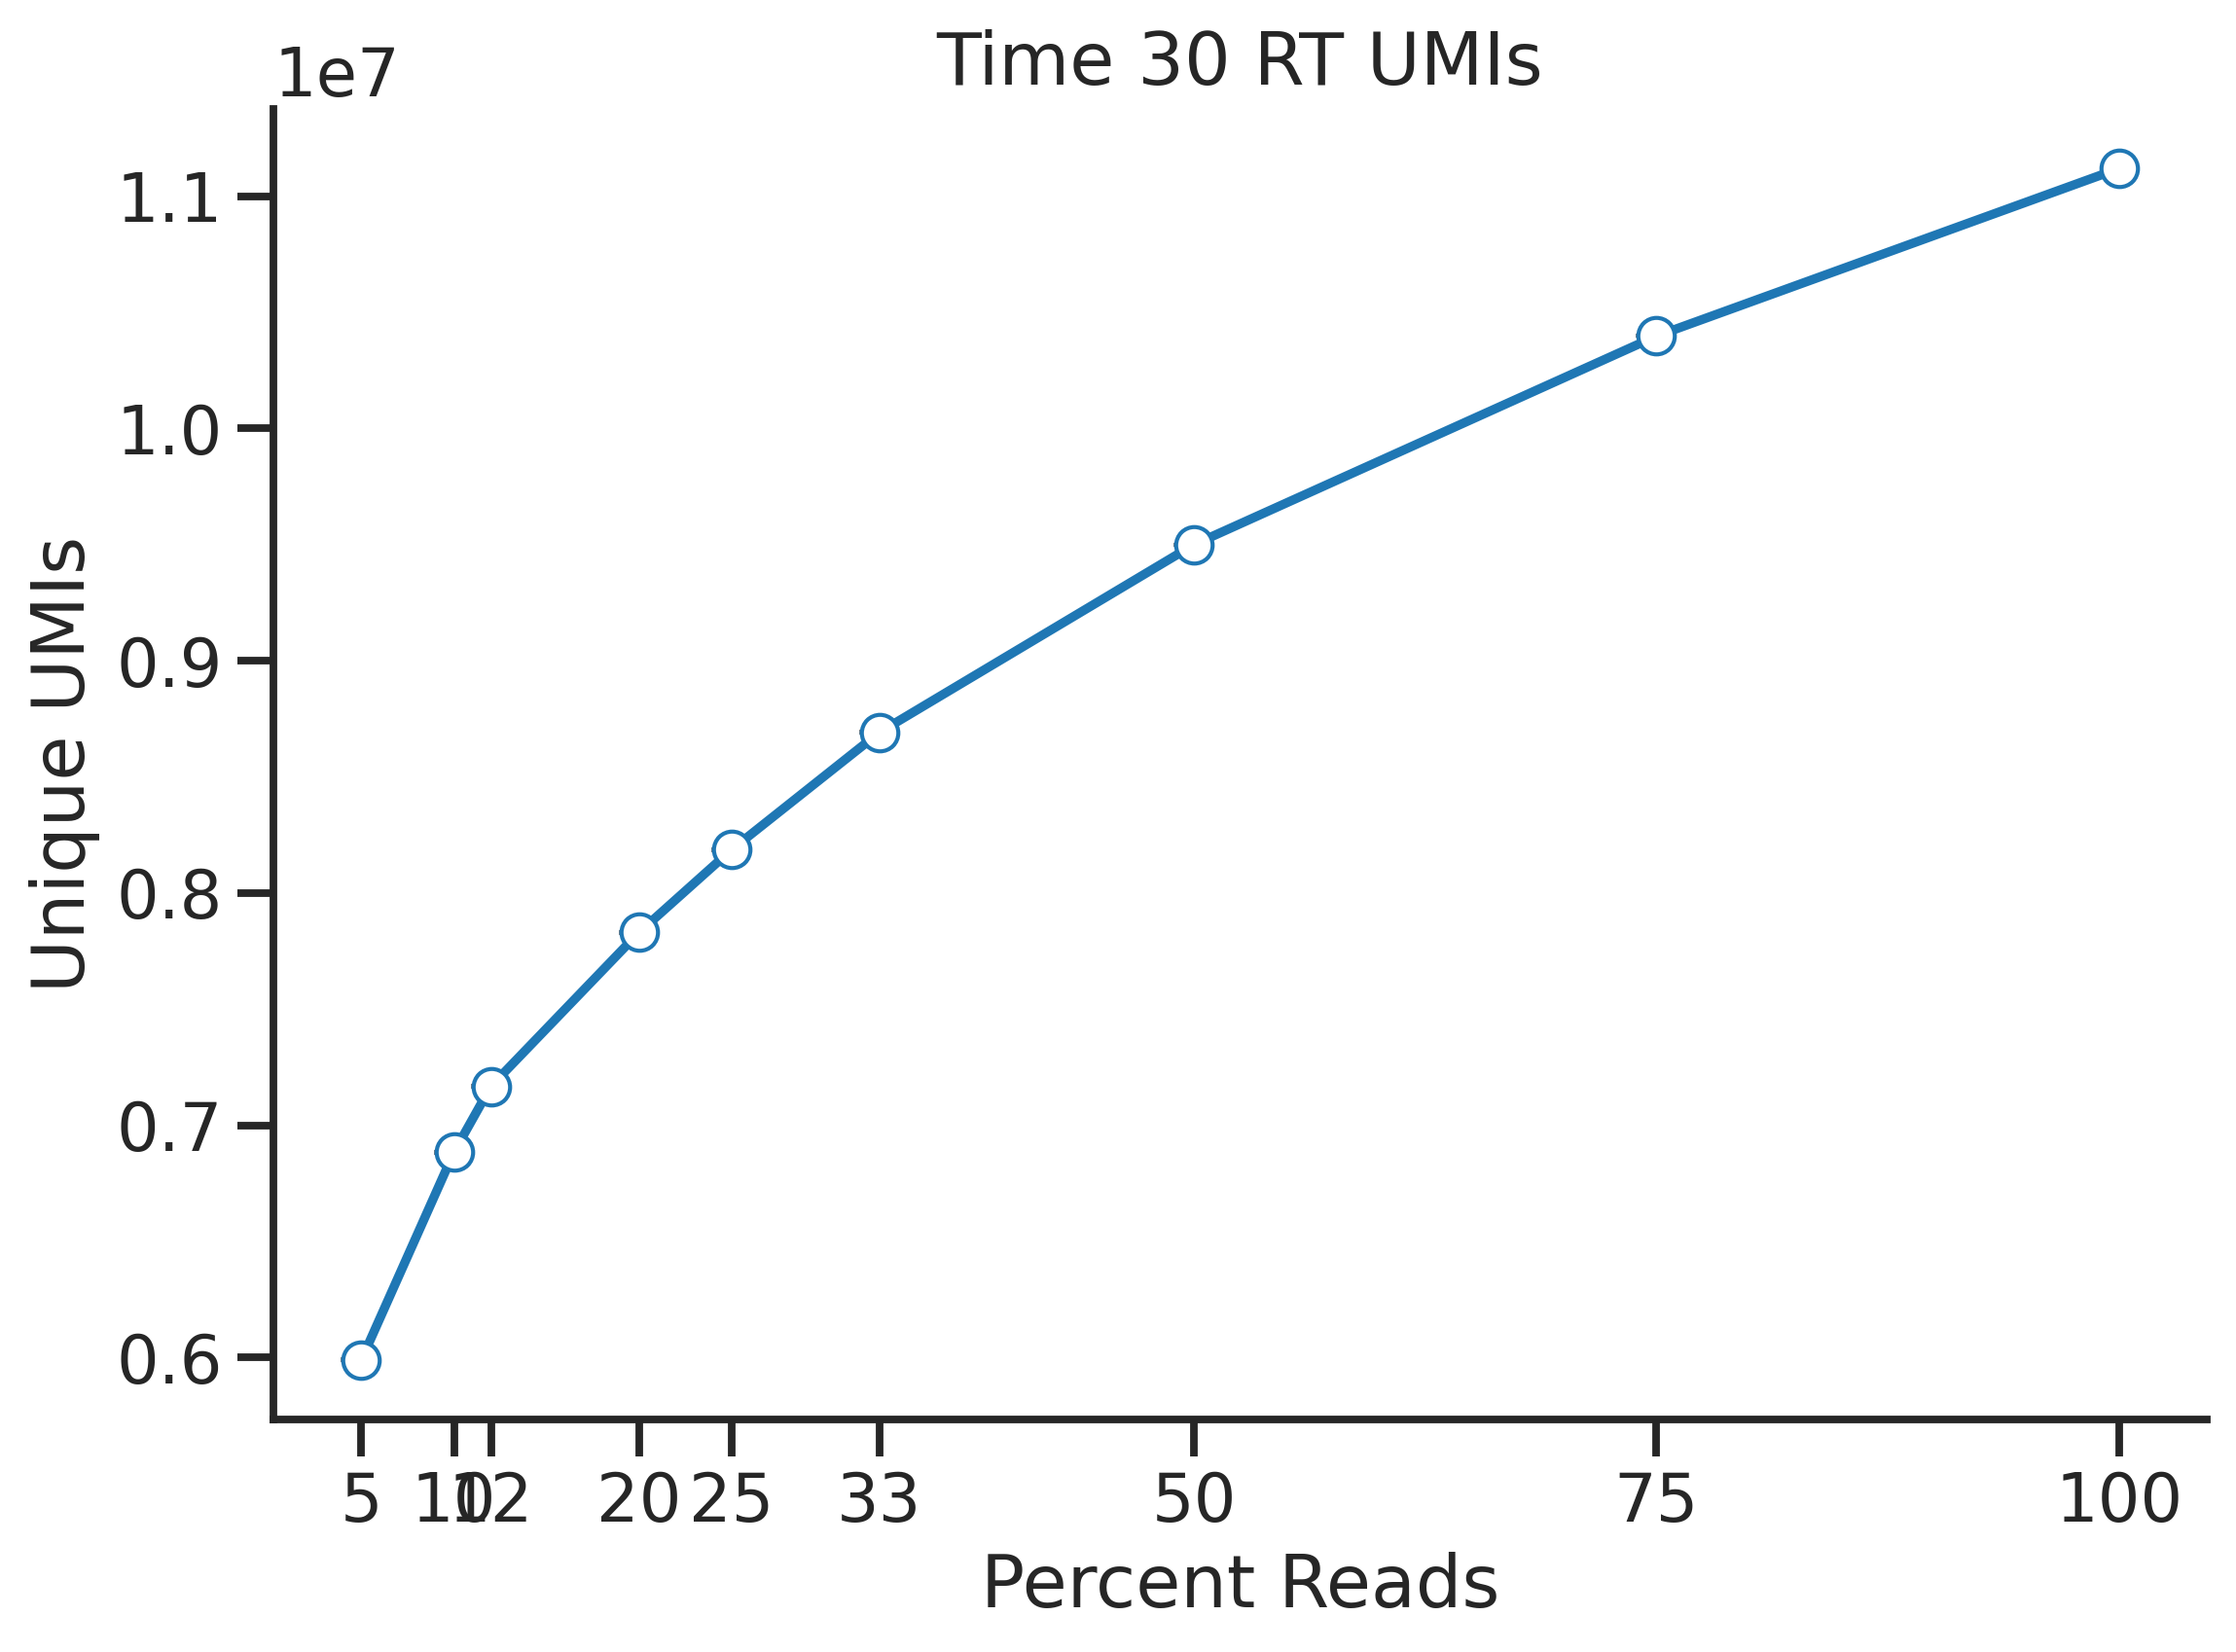

In [19]:
# If your df is named time_30_summary
sns.set(style="ticks")
sns.set_context('talk')

# Extract mean and std for unique_umis
y_mean = time_30_summary[('unique_umis', 'mean')]
y_std = time_30_summary[('unique_umis', 'std')]
x = time_30_summary['percent_reads']

# Plot
plt.figure(figsize=(8,6), dpi = 300)

ax = plt.errorbar(
    x=x,
    y=y_mean,
    yerr=y_std,
    fmt='-o',
    capsize=5,
    color='tab:blue',
    ecolor='tab:gray',
    elinewidth=2,
    markerfacecolor='white'
)

plt.xlabel("Percent Reads")
plt.ylabel("Unique UMIs")
plt.title("Time 30 RT UMIs")
plt.xticks(x)
plt.tight_layout()


sns.despine()

In [20]:
time_5_summary = df_with_all[df_with_all["time"] == "5"].groupby(["num_splits", "percent_reads", "time"]).agg([np.mean, np.std]).reset_index()
time_5_summary["percent_reads"] = time_5_summary["percent_reads"].astype(int)
time_5_summary

/tmp/ipykernel_3150114/1013219172.py:1: FutureWarning: The provided callable <function mean at 0x147d973b6980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  time_5_summary = df_with_all[df_with_all["time"] == "5"].groupby(["num_splits", "percent_reads", "time"]).agg([np.mean, np.std]).reset_index()
/tmp/ipykernel_3150114/1013219172.py:1: FutureWarning: The provided callable <function std at 0x147d973b6ac0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  time_5_summary = df_with_all[df_with_all["time"] == "5"].groupby(["num_splits", "percent_reads", "time"]).agg([np.mean, np.std]).reset_index()


num_splits percent_reads time  unique_umis             
                                        mean          std
0   1.000000           100    5  4447493.000          NaN
1   1.333333            75    5  3892247.000   469.518903
2   2.000000            50    5  3246868.500   456.083874
3   3.000000            33    5  2733837.000  1403.782034
4   4.000000            25    5  2441704.000   423.707446
5   5.000000            20    5  2249608.400   720.805660
6   8.000000            12    5  1926558.125   825.867239
7  10.000000            10    5  1804834.500   660.935406
8  20.000000             5    5  1519204.400   709.867326

In [23]:
time_5_summary.to_csv("../../output/downsampling_t5_summary.csv")

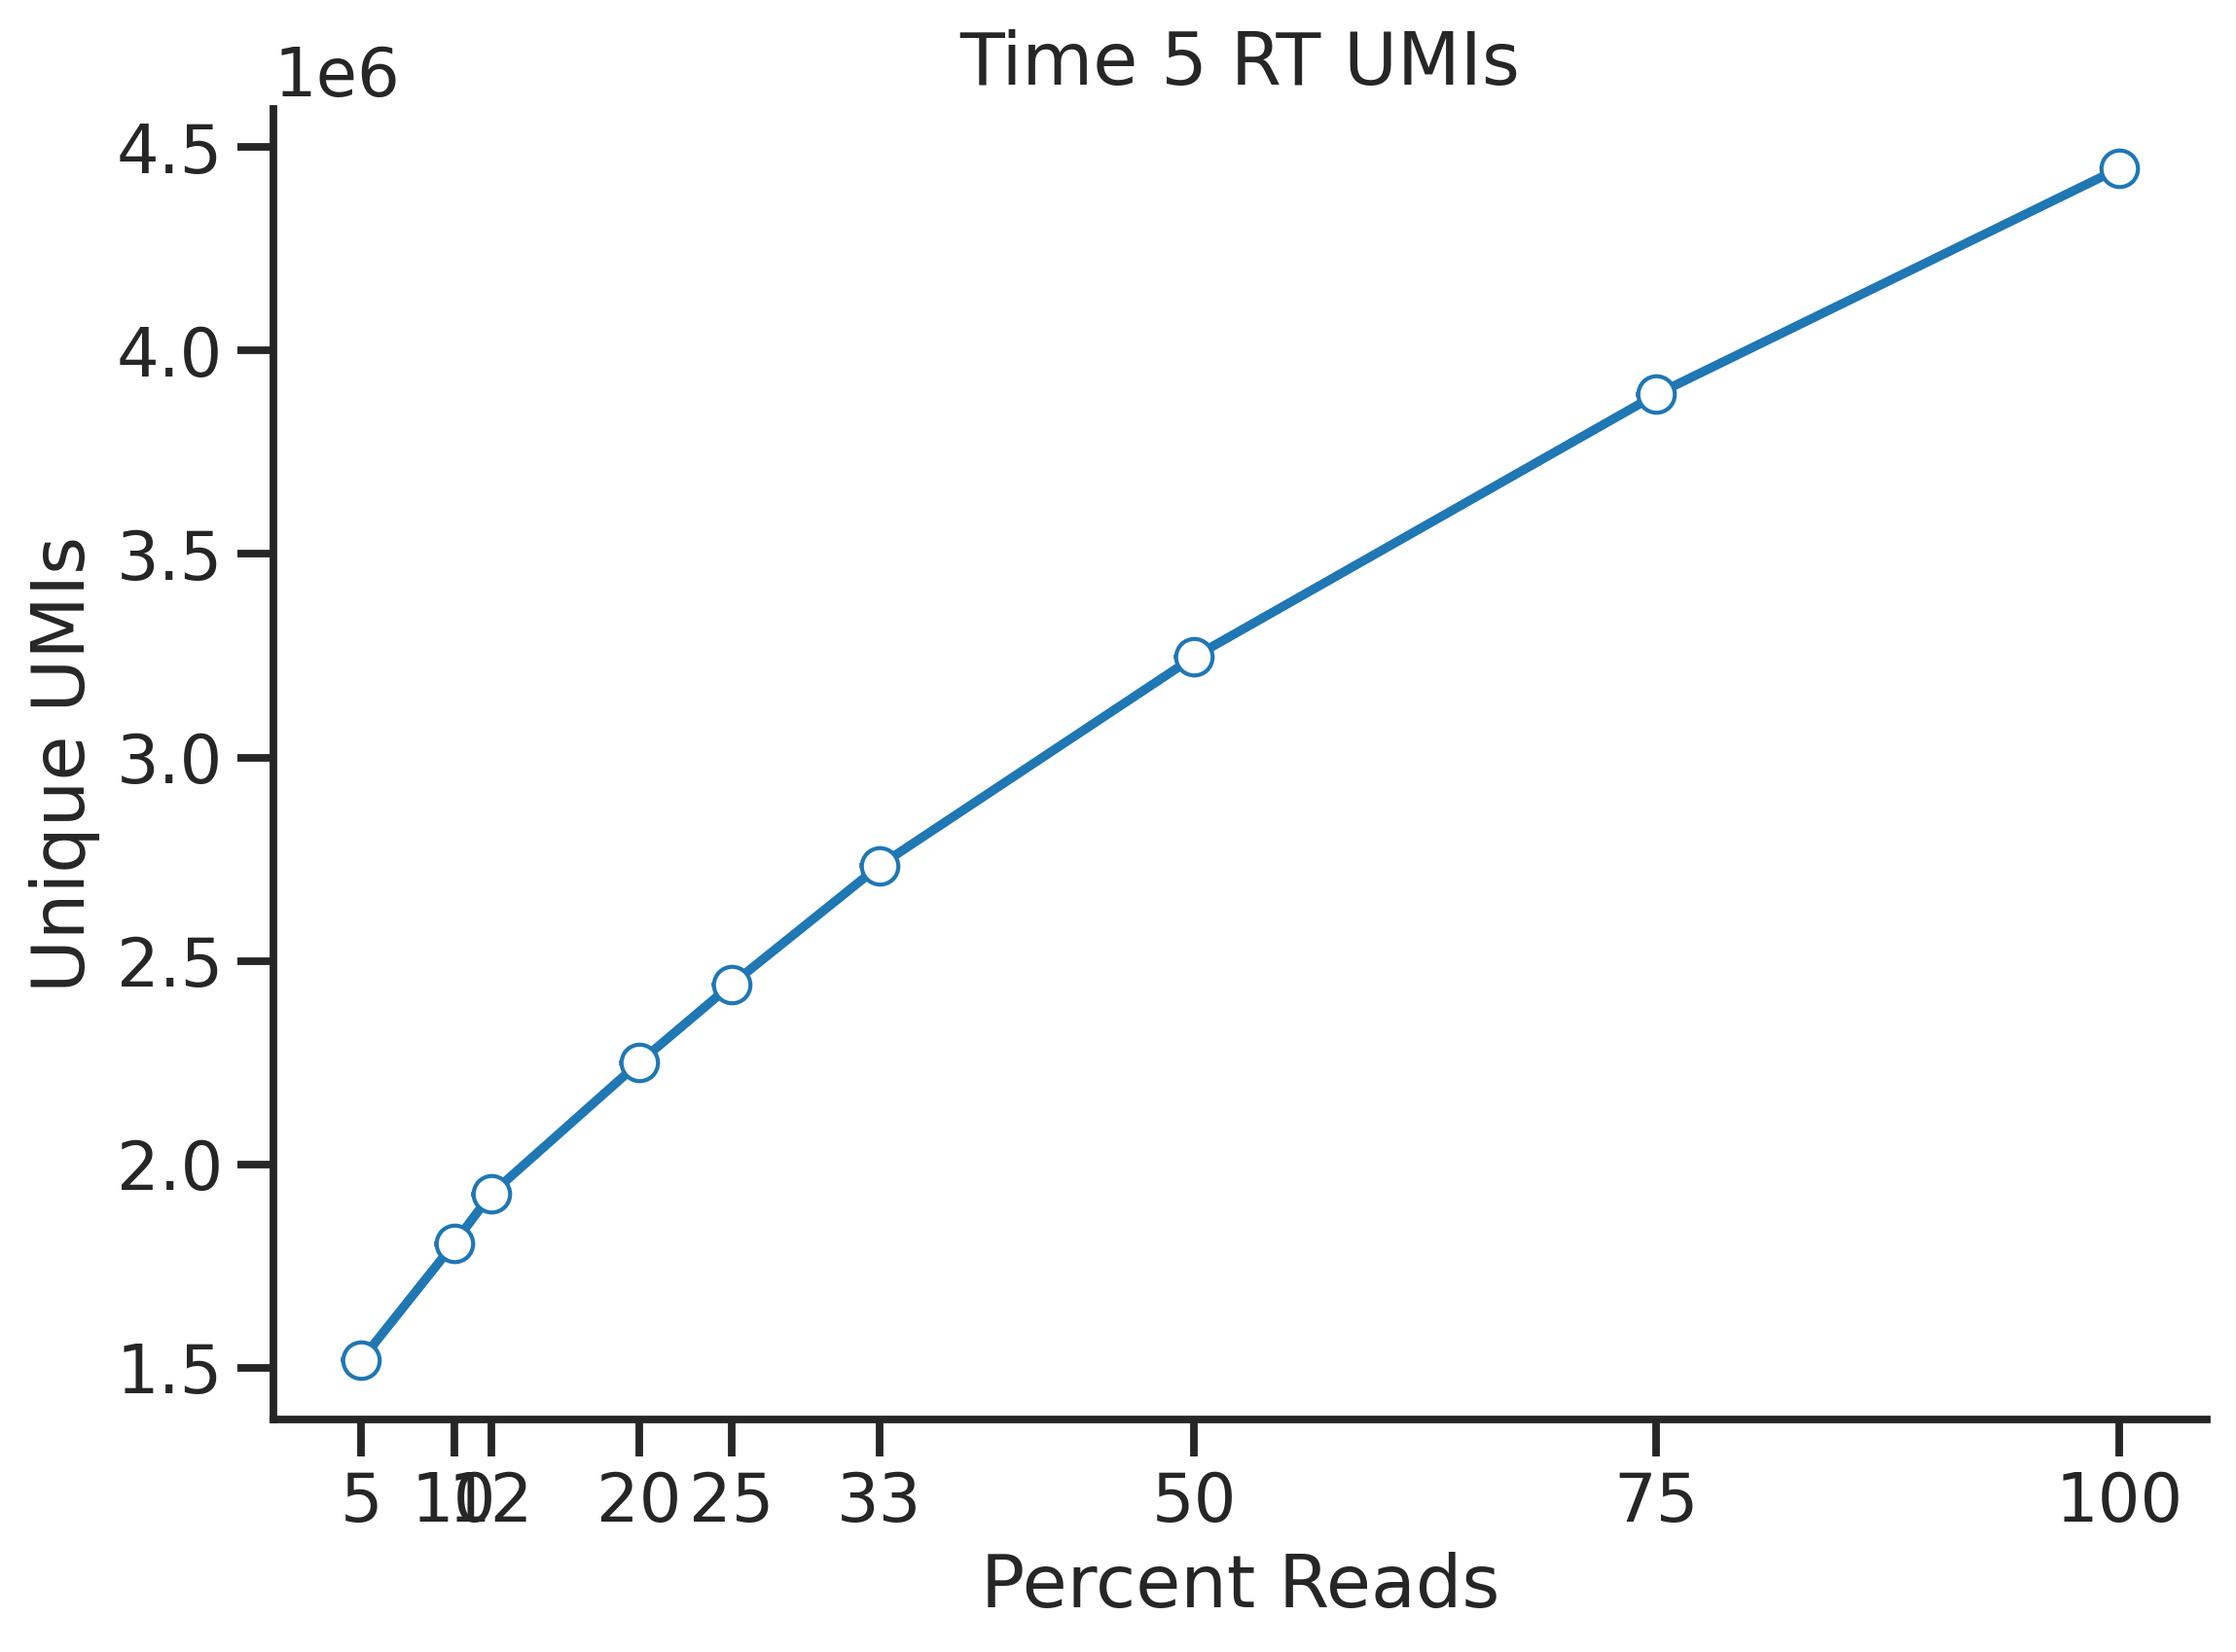

In [21]:
# If your df is named time_5_summary
sns.set(style="ticks")
sns.set_context('talk')

# Extract mean and std for unique_umis
y_mean = time_5_summary[('unique_umis', 'mean')]
y_std = time_5_summary[('unique_umis', 'std')]
x = time_5_summary['percent_reads']

# Plot
plt.figure(figsize=(8,6), dpi = 300)

ax = plt.errorbar(
    x=x,
    y=y_mean,
    yerr=y_std,
    fmt='-o',
    capsize=5,
    color='tab:blue',
    ecolor='tab:gray',
    elinewidth=2,
    markerfacecolor='white'
)

plt.xlabel("Percent Reads")
plt.ylabel("Unique UMIs")
plt.title("Time 5 RT UMIs")
plt.xticks(x)
plt.tight_layout()


sns.despine()

In [25]:
time_30_total_reads = 529157819
time_5_total_reads = 294858099

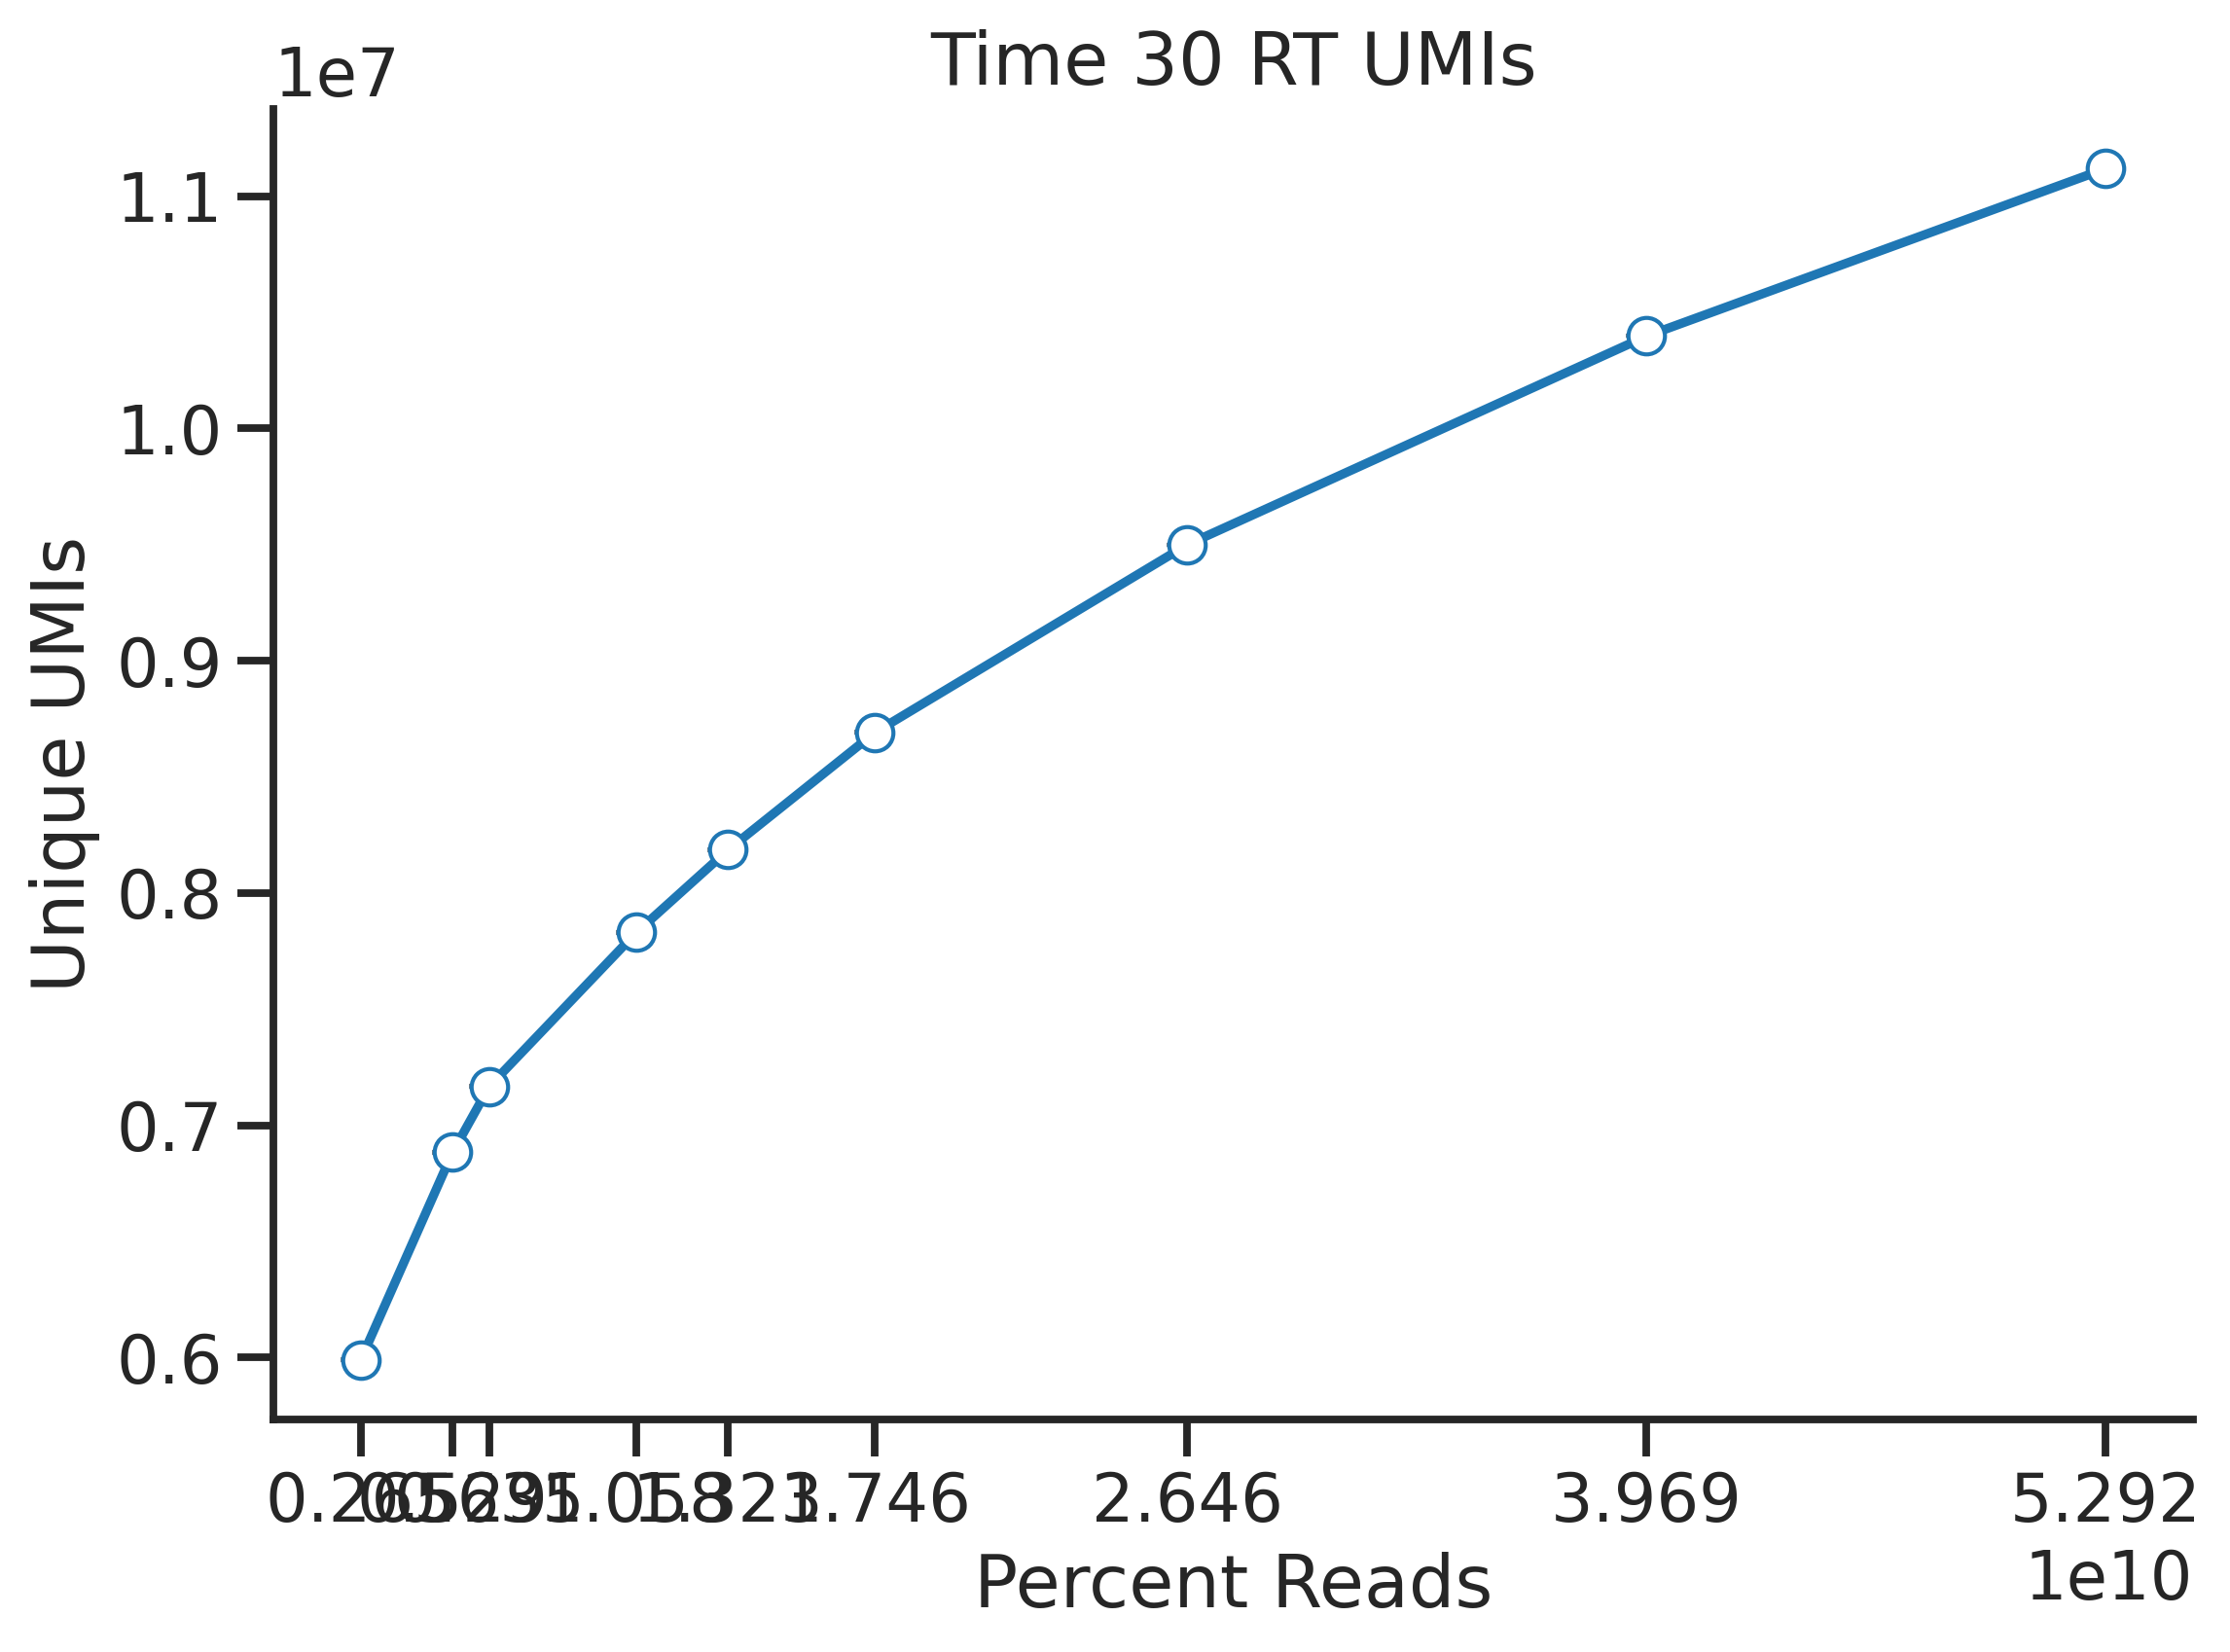

In [26]:
# If your df is named time_30_summary
sns.set(style="ticks")
sns.set_context('talk')

# Extract mean and std for unique_umis
y_mean = time_30_summary[('unique_umis', 'mean')]
y_std = time_30_summary[('unique_umis', 'std')]
x = time_30_summary['percent_reads'] * time_30_total_reads

# Plot
plt.figure(figsize=(8,6), dpi = 300)

ax = plt.errorbar(
    x=x,
    y=y_mean,
    yerr=y_std,
    fmt='-o',
    capsize=5,
    color='tab:blue',
    ecolor='tab:gray',
    elinewidth=2,
    markerfacecolor='white'
)

plt.xlabel("Percent Reads")
plt.ylabel("Unique UMIs")
plt.title("Time 30 RT UMIs")
plt.xticks(x)
plt.tight_layout()


sns.despine()

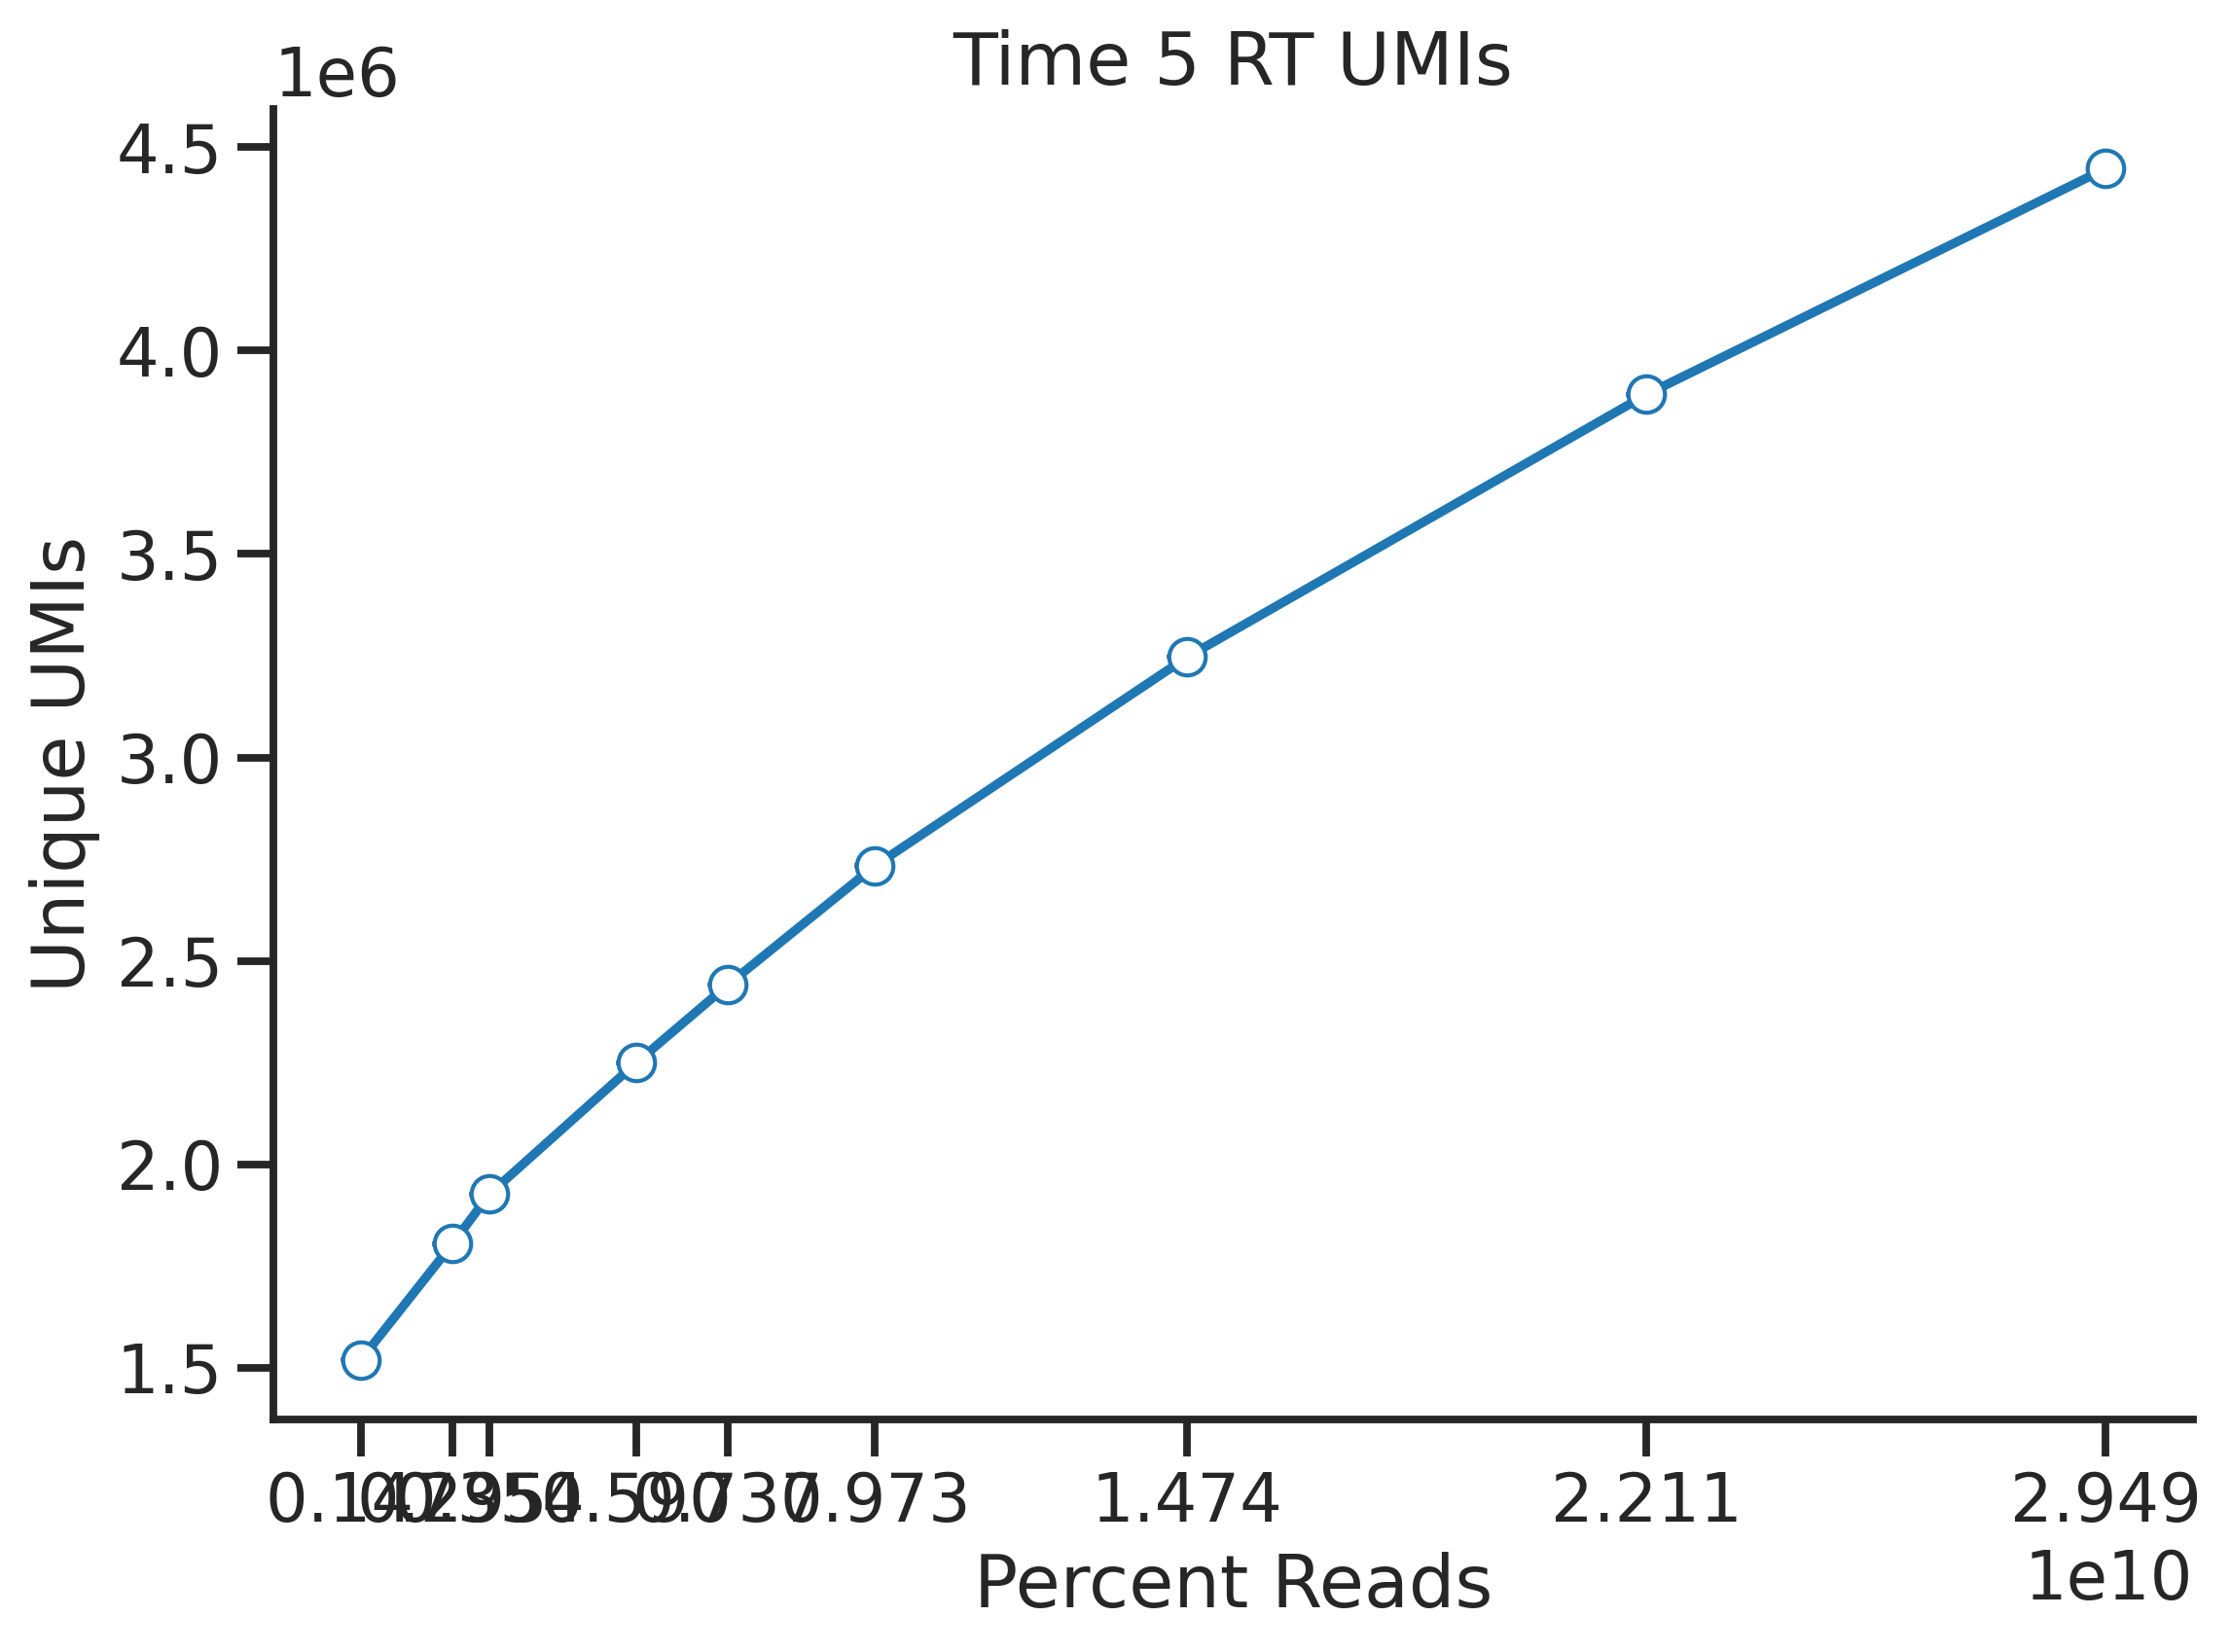

In [27]:
# If your df is named time_5_summary
sns.set(style="ticks")
sns.set_context('talk')

# Extract mean and std for unique_umis
y_mean = time_5_summary[('unique_umis', 'mean')]
y_std = time_5_summary[('unique_umis', 'std')]
x = time_5_summary['percent_reads'] * time_5_total_reads

# Plot
plt.figure(figsize=(8,6), dpi = 300)

ax = plt.errorbar(
    x=x,
    y=y_mean,
    yerr=y_std,
    fmt='-o',
    capsize=5,
    color='tab:blue',
    ecolor='tab:gray',
    elinewidth=2,
    markerfacecolor='white'
)

plt.xlabel("Percent Reads")
plt.ylabel("Unique UMIs")
plt.title("Time 5 RT UMIs")
plt.xticks(x)
plt.tight_layout()


sns.despine()

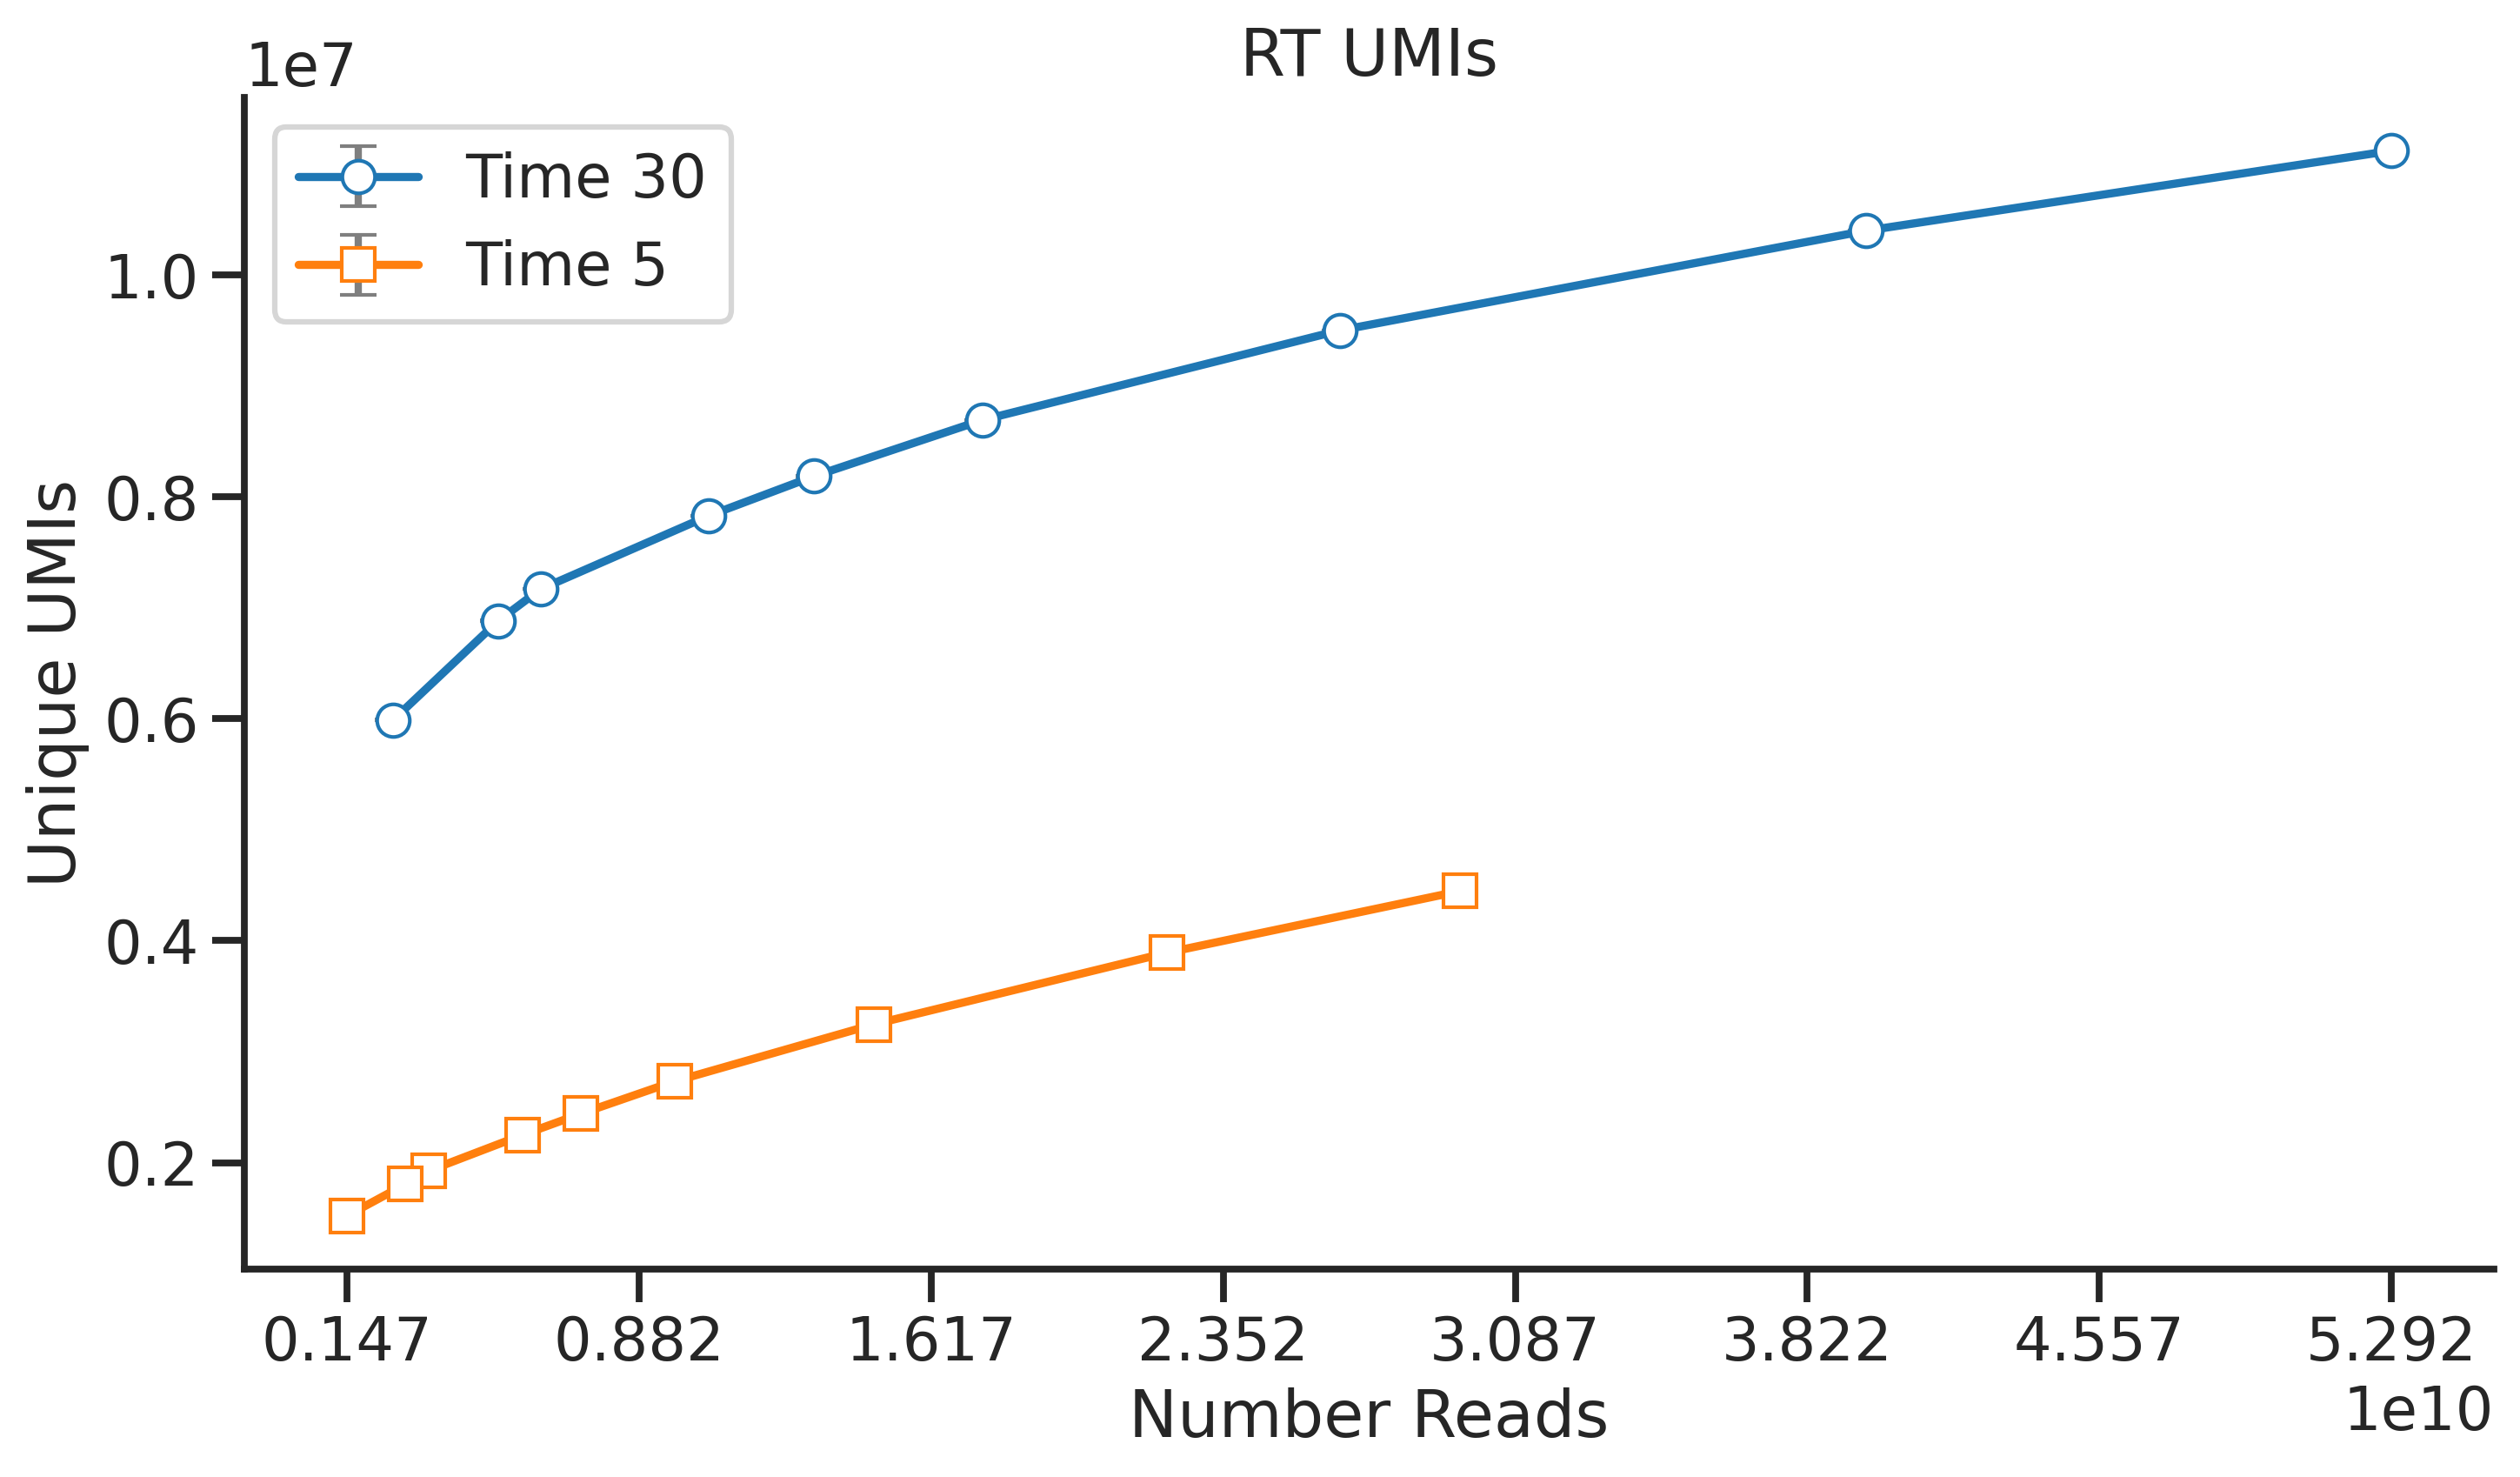

In [35]:
sns.set(style="ticks")
sns.set_context('talk')

plt.figure(figsize=(10,6), dpi=300)

# --- Time 30 ---
x_30 = time_30_summary['percent_reads'] * time_30_total_reads
y_mean_30 = time_30_summary[('unique_umis', 'mean')]
y_std_30 = time_30_summary[('unique_umis', 'std')]

plt.errorbar(
    x=x_30,
    y=y_mean_30,
    yerr=y_std_30,
    fmt='-o',
    capsize=5,
    color='tab:blue',
    ecolor='tab:gray',
    elinewidth=2,
    markerfacecolor='white',
    label='Time 30'
)

# --- Time 5 ---
x_5 = time_5_summary['percent_reads'] * time_5_total_reads
y_mean_5 = time_5_summary[('unique_umis', 'mean')]
y_std_5 = time_5_summary[('unique_umis', 'std')]

plt.errorbar(
    x=x_5,
    y=y_mean_5,
    yerr=y_std_5,
    fmt='-s',
    capsize=5,
    color='tab:orange',
    ecolor='tab:gray',
    elinewidth=2,
    markerfacecolor='white',
    label='Time 5'
)

# Labels, legend, title
plt.xlabel("Number Reads")
plt.ylabel("Unique UMIs")
plt.title("RT UMIs")

# --- Standard / more frequent x-ticks ---
all_x = np.concatenate([x_30, x_5])
plt.xticks(np.linspace(all_x.min(), all_x.max(), 8))  # 8 evenly spaced ticks

plt.legend()
plt.tight_layout()
sns.despine()
plt.show()


# Correlating UMIS per barcode

In [51]:
# Loading in all rows
umi_30_all = []

for path in tqdm(glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_30_*4_chunks_*simple_umi_counts.tsv")):
    umi_30_all.append(pd.read_csv(path, sep = "\t"))
    
umi_30_all = pd.concat(umi_30_all)
umi_30_all

100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


,RPTR_BC,count
0,CATTCATAAAGAAC,87511
1,CCAACGGTGTCGAA,57171
2,TGTATCCATCTACC,54036
3,TGCATCTAGATAAA,52356
4,TACAACCGGCAAGG,52079
...,...,...
949729,GGTTATAAGAGTGC,1
949730,TTGTCGCGTCTTCA,1
949731,GTATTGGGAGTGGC,1
949732,GTCGACTCAAAGGG,1


In [53]:
umi_30_all_grouped = umi_30_all.groupby("RPTR_BC").sum()
umi_30_all_grouped

,count
RPTR_BC,
AAAAAAAAAAAAAA,15
AAAAAAAAAAAAAG,3
AAAAAAAAAAAAAT,1
AAAAAAAAAAAACA,10
AAAAAAAAAAAAGA,4
...,...
TTTTTTTTTCAGTT,1
TTTTTTTTTCGGGG,1
TTTTTTTTTTAGGA,1


In [52]:
# Loading in all rows
umi_5_all = []

for path in tqdm(glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*_5_*4_chunks_*simple_umi_counts.tsv")):
    umi_5_all.append(pd.read_csv(path, sep = "\t"))
    
umi_5_all = pd.concat(umi_5_all)
umi_5_all

100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


,RPTR_BC,count
0,CATTCATAAAGAAC,13972
1,TACAACCGGCAAGG,10260
2,CCAACGGTGTCGAA,10009
3,TGTATCCATCTACC,9347
4,TGCATCTAGATAAA,9033
...,...,...
546009,ACGTAAGGAAGACA,1
546010,GTGTGTGAAGACTG,1
546011,GGGCTGGTGGGTCG,1
546012,GCCGCGACTGGGTA,1


In [54]:
umi_5_all_grouped = umi_5_all.groupby("RPTR_BC").sum()
umi_5_all_grouped

,count
RPTR_BC,
AAAAAAAAAAAAAA,11
AAAAAAAAAAAAAT,1
AAAAAAAAAAAACA,5
AAAAAAAAAAAAGA,3
AAAAAAAAAAAAGG,1
...,...
TTTTTTTTGTTGGG,1
TTTTTTTTGTTTAT,1
TTTTTTTTTGGGCG,1


In [76]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import re
from pathlib import Path

def process_partial_file_rptr_bc(path, ref_5_df, ref_30_df):
    path = Path(path)
    
    # Extract timepoint from filename
    m = re.search(r"RPTR_1_(\d+)_", path.name)
    if not m:
        return None
    timepoint = int(m.group(1))
    ref_df = ref_5_df if timepoint == 5 else ref_30_df
    
    # Extract num_splits and percent_reads
    n_splits_match = re.search(r"_(\d+)_chunks", path.name)
    if not n_splits_match:
        return None
    num_splits = int(n_splits_match.group(1))
    percent_reads = 100 / num_splits
    
    # Read CSV with RPTR_BC
    try:
        df = pd.read_csv(
            path,
            sep="\t",
            usecols=["RPTR_BC", "count"],
            dtype={"RPTR_BC": "category", "count": "int32"}
        )
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None

    # Aggregate reads by RPTR_BC
    partial_grouped = df.groupby("RPTR_BC")["count"].sum().reset_index(name="partial_count")
    
    # Merge with reference dataframe on RPTR_BC
    merged = pd.merge(
        ref_df, 
        partial_grouped, 
        on="RPTR_BC", 
        how="inner"
    )

    # Compute correlation if there are enough overlapping RPTR_BC
    if len(merged) < 2:
        corr = np.nan
    else:
        corr = np.corrcoef(merged["count"], merged["partial_count"])[0,1]

    return {
        "file": str(path),
        "timepoint": timepoint,
        "percent_reads": percent_reads,
        "correlation": corr
    }
# ---- Run in parallel using threads with progress ----
results = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_partial_file_rptr_bc, path, umi_5_all, umi_30_all): path
               for path in glob.glob("../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_*/*simple_umi_counts.tsv")}  # all files
    for f in tqdm(as_completed(futures), total=len(futures), desc="Processing RPTR_BC counts"):
        res = f.result()
        if res:
            results.append(res)

# ---- Final DataFrame ----
df_correlations = pd.DataFrame(results)
df_correlations

Processing RPTR_BC counts:   0%|          | 0/104 [00:00<?, ?it/s]

/tmp/ipykernel_3150114/277901966.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  partial_grouped = df.groupby("RPTR_BC")["count"].sum().reset_index(name="partial_count")
/tmp/ipykernel_3150114/277901966.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  partial_grouped = df.groupby("RPTR_BC")["count"].sum().reset_index(name="partial_count")
/tmp/ipykernel_3150114/277901966.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this

,file,timepoint,percent_reads,correlation
0,../../output/GCN4/downsampling/trebl_experimen...,5,5.0,0.996871
1,../../output/GCN4/downsampling/trebl_experimen...,5,5.0,0.996773
2,../../output/GCN4/downsampling/trebl_experimen...,30,5.0,0.998931
3,../../output/GCN4/downsampling/trebl_experimen...,30,5.0,0.998939
4,../../output/GCN4/downsampling/trebl_experimen...,5,12.5,0.998887
...,...,...,...,...
99,../../output/GCN4/downsampling/trebl_experimen...,30,5.0,0.998924
100,../../output/GCN4/downsampling/trebl_experimen...,5,10.0,0.998415
101,../../output/GCN4/downsampling/trebl_experimen...,5,20.0,0.999612
102,../../output/GCN4/downsampling/trebl_experimen...,30,12.5,0.999718


In [94]:
def process_partial_file_rptr_bc(path, ref_5_df, ref_30_df):
    path = Path(path)
    
    # Extract timepoint from filename
    m = re.search(r"RPTR_1_(\d+)_", path.name)
    if not m:
        return None
    timepoint = int(m.group(1))
    ref_df = ref_5_df if timepoint == 5 else ref_30_df
    
    # Extract num_splits and percent_reads
    n_splits_match = re.search(r"_(\d+)_chunks", path.name)
    if not n_splits_match:
        return None
    num_splits = int(n_splits_match.group(1))
    percent_reads = 100 / num_splits
    
    # Read CSV with RPTR_BC
    try:
        df = pd.read_csv(
            path,
            sep="\t",
            usecols=["RPTR_BC", "count"],
            dtype={"RPTR_BC": "category", "count": "int32"}
        )
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None

    # Aggregate reads by RPTR_BC
    partial_grouped = df.groupby("RPTR_BC")["count"].sum().reset_index(name="partial_count")
    
    # Merge with reference dataframe on RPTR_BC
    return pd.merge(
        ref_df, 
        partial_grouped, 
        on="RPTR_BC", 
        how="inner"
    )



In [78]:
df_correlations.to_csv("../../output/downsampling_correlations.csv")

In [81]:
min(df_correlations["correlation"])

0.996773328546673

In [88]:
df_correlations["file"].iloc[0]

'../../output/GCN4/downsampling/trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_R1_001_20_chunks_part_7/RPTR_1_5_S2_R1_001_20_chunks_part_7.fq_simple_umi_counts.tsv'

<Axes: xlabel='percent_reads', ylabel='correlation'>

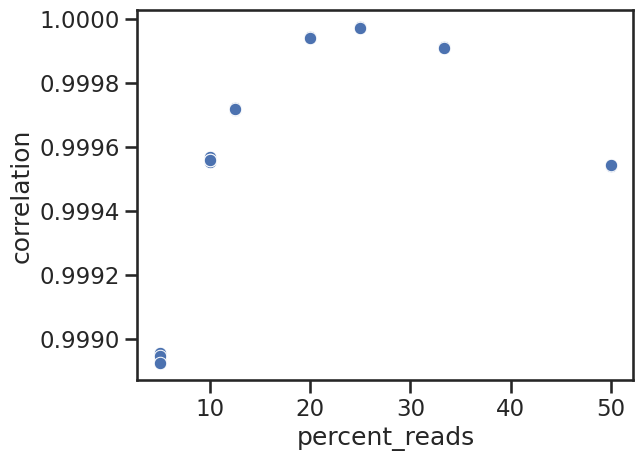

In [84]:
df_correlations_5 = df_correlations[df_correlations["timepoint"] == 30]
sns.scatterplot(data = df_correlations_5, x = "percent_reads", y = "correlation")

<Axes: xlabel='percent_reads', ylabel='correlation'>

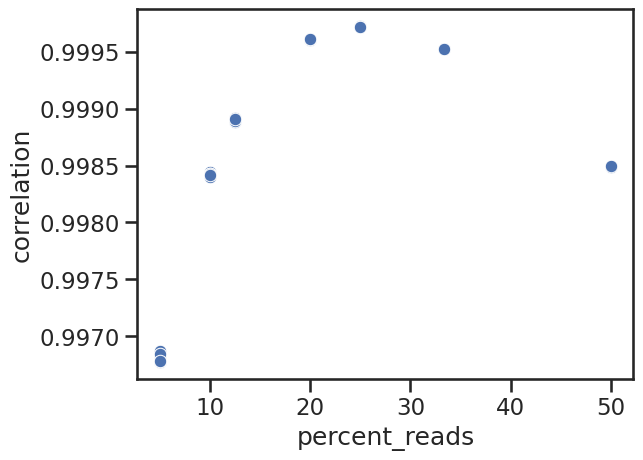

In [85]:
df_correlations_5 = df_correlations[df_correlations["timepoint"] == 5]
sns.scatterplot(data = df_correlations_5, x = "percent_reads", y = "correlation")

In [ ]:
# For each file in chunk_umi_count_paths, drop RPTR_BC column, groupby UMI to get sum 
# Merge with corresponding 100% reads on each (with umi_5_all_grouped if "RPTR_1_(\d+)_" in file name gives 5 else with umi_30_all_grouped)
# Calculate correlation between counts
# Save in a table

chunk_umi_count_paths